# block modeling and bi-clustering 

## Trying block modeling and bi-clustering (I think) example code

Based on https://stats.stackexchange.com/a/138331  (which was answer for https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix)

Initial ordering: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Initial covariance matrix score: -2346.700128954904
Best ordering: [84 27 80 17 63  5 47 18  8 92 89 30 12 31 14 15 82 42 76 23  4 49 39 24
 36 97 58 99 74 51 20  6 38 33 59 87 60 19 57 28 53 46 79 62 61 29 91 10
 50 35 94 78 67 81 54 44 32 21 45 22 34  1 52 90 88 96 69  9  7 73 86 71
 43 40 56 26 83 77 68 64 75  2 55 65  3 13 25 72 70 41 16 11  0 98 93 95
 37 66 48 85]
Best score: -23.442231910974186
Cluster     [variables assigned to this cluster]
------------------------------------------------
Cluster 01  [84 27 80 17 63  5 47 18  8 92 89 30 12 31 14 15 82 42 76 23]
Cluster 02  [ 4 49 39 24 36 97 58 99 74 51 20  6 38 33 59 87 60 19 57 28]
Cluster 03  [53 46 79 62 

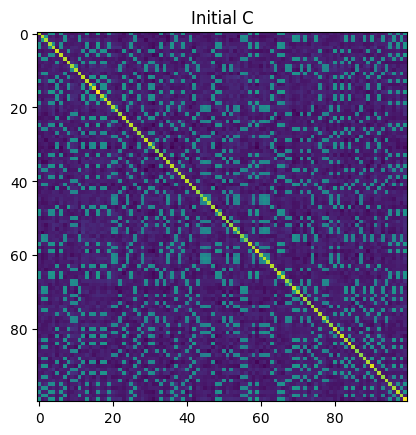

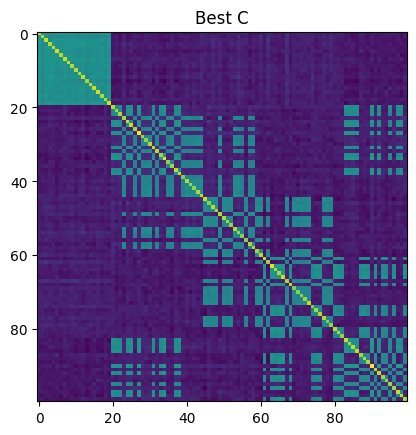

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# This generates 100 variables that could possibly be assigned to 5 clusters
n_variables = 100
n_clusters = 5
n_samples = 1000

# To keep this example simple, each cluster will have a fixed size
cluster_size = n_variables // n_clusters

# Assign each variable to a cluster
belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(
        np.random.randn(n_samples) + latent[belongs_to_cluster[i], :]
    )

variables = np.array(variables)

C = np.cov(variables)

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print ('Initial ordering:', initial_ordering)
print ('Initial covariance matrix score:', initial_score)

# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 1000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print ('Best ordering:', current_ordering)
print ('Best score:', current_score)
print
print ('Cluster     [variables assigned to this cluster]')
print ('------------------------------------------------')
for cluster in range(n_clusters):
    print ('Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]))

## Based on Spectral Co-Clustering algorithm

[A demo of the Spectral Co-Clustering algorithm](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html)
>"This example demonstrates how to generate a dataset and bicluster it using the Spectral Co-Clustering algorithm.

Found based on comment by chanp to OP at https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix)
>"FYI, this problem is called bi-clustering. A demo of it can be found at scikit-learn.org/stable/auto_examples/bicluster/… – chanp Feb 18 '16 at 14:20

consensus score: 1.000


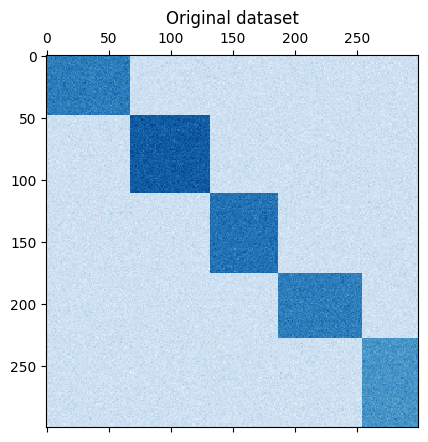

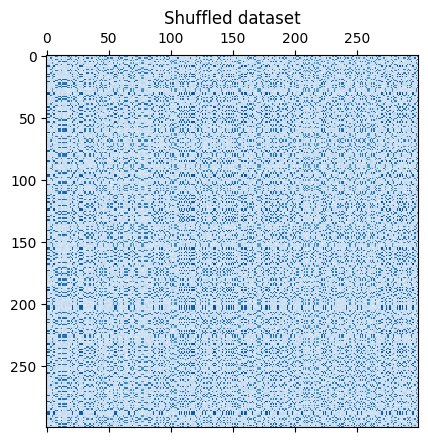

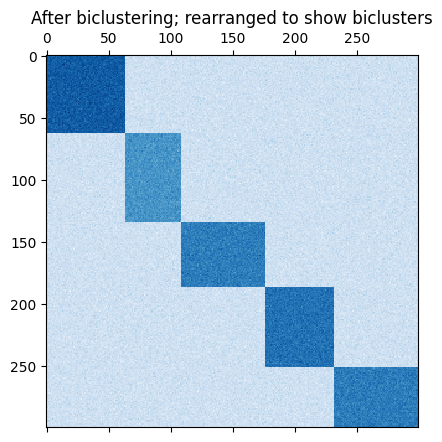

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=5, noise=5,
    shuffle=False, random_state=0)
#print(data)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(data.shape[0])
col_idx = rng.permutation(data.shape[1])
data = data[row_idx][:, col_idx]

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(data)
#print(len(model.row_labels_))
#print(model.column_labels_)
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

Note luckily it seems Scikit-learn/sklearn now works with pandas dataframes so you can plug in your dataframes to these demonstration approaches easily.

-----

-----